In [ ]:
# %pip install tensorflow
# %pip install gym
# %pip install keras
# %pip install keras-rl2
# %pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu117

In [1]:
from gym import Env
from gym.spaces import Discrete, Box
from matplotlib import pyplot as plt
from mss import mss
import numpy as np 
import time
import pydirectinput
import pygetwindow
import cv2
import win32gui
import pytesseract
import gym as gym
from image_analysis.take_screenshot import Screenshot
from input_sending.input_sending import SendInput 
from text_recognition.text_recog import RecognizeText 
from pattern_recognition.pattern_recog import RecognizePattern 

In [2]:
class StepManiaEnv(Env):
    
    # Setup
    def __init__(self):
        super().__init__()
        self.action_space = Discrete(5)

        # Observation Array
        self.observation_space = Box(
            low=0, 
            high=255, 
            shape=(1, 135, 100), # does this work?
            dtype=np.uint8
        )
        
        # Define extraction parameters for the game
        self.screenshot_helper = Screenshot()
        self.text_recog_helper = RecognizeText()
        self.input_sending_helper = SendInput()
        self.capture = mss()
        self.steps = 0
        self.window_location = {'top': 35, 'left': 10, 'width': 410, 'height': 230}
        self.game_location = {'top': 15, 'left': 20, 'width': 100, 'height': 185}
        self.score_location = {'top': 215, 'left': 280, 'width': 100, 'height': 25}
        self.done_location = {'top': 0, 'left': 0, 'width': 80, 'height':25}
        self.cur_held_buttons = {'a': False, 'd': False, 'w': False, 's': False}
        pytesseract.pytesseract.tesseract_cmd = r'G:\Programme\Tesseract\tesseract.exe'
        
        win = pygetwindow.getWindowsWithTitle('StepMania')[0]
        win.size = (450, 290)
        win.moveTo(0, 0)

    # What is called to do something in the game
    def step(self, action):
        
        # Action dictionary
        action_map = {
            0:'no_op',
            1:'a',
            2:'d',
            3:'w',
            4:'s',
        }
        start = time.perf_counter()

        # Manage and send input based on action parameter
        if action != 0:
            if (list(self.cur_held_buttons.values())[action - 1]):
                self.cur_held_buttons[list(self.cur_held_buttons)[action - 1]] = False
                self.input_sending_helper.releaseKey(action_map[action])
            else:
                self.cur_held_buttons[list(self.cur_held_buttons)[action - 1]] = True
                self.input_sending_helper.holdKey(action_map[action])
        

        # Take screenshot for done, observation and reward functions
        screenshot = np.array(self.capture.grab(self.window_location))[:,:,:-1].astype(np.uint8)
        gray_screenshot = cv2.cvtColor(screenshot, cv2.COLOR_BGR2GRAY)
        downscaled_screenshot = self.screenshot_helper.downscaleImage(screenshot, (225, 150), (1, 150, 225))
        self.steps += 1

        # Checking if the game is over
        done = self.get_over(gray_screenshot)

        # Get the next observation
        new_observation = self.get_observation(downscaled_screenshot)
        
        # Use score as reward
        reward = self.get_reward(gray_screenshot)
        info = {}
        stop = time.perf_counter()

        return new_observation, reward, done, info

    # Restart the game
    def reset(self):
        
        # Exit to menu, select new song and start
        time.sleep(5)
        pydirectinput.press('enter')
        time.sleep(5)
        pydirectinput.press('d')
        time.sleep(2)
        pydirectinput.press('enter')

        # Edge Case - 'Roulette' is selected
        time.sleep(1.2)
        pydirectinput.press('enter')
        time.sleep(3)
        pydirectinput.press('enter')

        # Take screenshot to pass to observation
        screenshot = np.array(self.capture.grab(self.window_location))[:,:,:-1].astype(np.uint8)
        downscaled_screenshot = self.screenshot_helper.downscaleImage(screenshot, (225, 150), (1, 150, 225))
        
        return self.get_observation(downscaled_screenshot)

    # Get the part of observation of the game that we want
    def get_observation(self, img):

        # Crop gameplay part of the window screenshot
        obs = img[:, self.game_location['top']:(self.game_location['top'] + self.game_location['height']), self.game_location['left']:(self.game_location['left'] + self.game_location['width'])]

        return obs

    # Get the current score as a reward
    def get_reward(self, img):

        # Crop score part of the window screenshot
        obs = img[self.score_location['top']:(self.score_location['top'] + self.score_location['height']), self.score_location['left']:(self.score_location['left'] + self.score_location['width'])]

        return self.text_recog_helper.get_number_from_image(obs)

    # Get if the game is over
    def get_over(self, img):

        # Crop done part of the window screenshot
        obs = img[self.done_location['top']:(self.done_location['top'] + self.done_location['height']), self.done_location['left']:(self.done_location['left'] + self.done_location['width'])]
        # Valid done text
        done_strings = ['‘our Results', 'Your Results']

        return self.text_recog_helper.is_text_in_image(obs, done_strings, 12)


In [3]:
env = StepManiaEnv()

In [ ]:
print('Environment started - Using random inputs')
for episode in range(10):
  done = False
  final_reward = 0
  start = time.perf_counter()
  while not done:
    obs, reward, done, info = env.step(env.action_space.sample())
    final_reward = reward

  stop = time.perf_counter()
  final_time = stop - start
  env.reset()
  print(f'Total Reward for episode {episode} is {final_reward}')
  print(f'Total screenshots for episode {episode} is {env.steps}')
  print(f'Total duration of episode {episode} is {final_time:0.4f} seconds')
  print(f'This equals an average of {env.steps / final_time} images per second')

In [3]:
import os
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common import env_checker

In [ ]:
# Check if the environment is valid
env_checker.check_env(env)

In [4]:
class TrainAndLoggingCallback(BaseCallback):
  def __init__(self, checking_freq, save_path, verbose=1):
    super(TrainAndLoggingCallback, self).__init__(verbose)
    self.checking_freq = checking_freq
    self.save_path = save_path

  def _init_callback(self):
    if self.save_path is not None:
      os.makedirs(self.save_path, exist_ok=True)

  def _on_step(self):
    if self.n_calls % self.checking_freq == 0:
      model_path = os.path.join(self.save_path, f'best_model_{self.n_calls}')
      self.model.save(model_path)
    
    return True

In [5]:
CHECKPOINT_DIR = './training/'
LOG_DIR = './logs/'

In [6]:
callback = TrainAndLoggingCallback(checking_freq=1_000, save_path=CHECKPOINT_DIR)

In [7]:
from stable_baselines3 import DQN
from stable_baselines3.common.monitor import Monitor

In [8]:
env = StepManiaEnv()

In [19]:
env = gym.make("StepManiaEnv-v1")
env = Monitor(env, LOG_DIR)

In [9]:
model = DQN(
  'CnnPolicy',              
  env,                      # Used environment
  tensorboard_log=LOG_DIR,  # Log directory
  verbose=1,                # Enables logging
  buffer_size=120_000,      # Buffer size depending on amount of ram
  learning_starts=1_000,    # Learning starts after 1000 steps
  device='cpu'             # Training on cpu or gpu
)

Using cpu device
Wrapping the env in a DummyVecEnv.


In [17]:
# Start training
model.learn(total_timesteps=1_000, callback=callback)

Logging to ./logs/DQN_13


In [ ]:
# Load past model 
model.load(r'training\best_model_1000')

In [ ]:
print('Environment started - Using Model')
for episode in range(10):
  obs = env.reset()
  done = False
  final_reward = 0
  start = time.perf_counter()
  while not done:
    action, _ = model.predict(obs)
    obs, reward, done, info = env.step(int(action))
    final_reward = reward

  stop = time.perf_counter()
  final_time = stop - start

  print(f'Total Reward for episode {episode} is {final_reward}')
  print(f'Total screenshots for episode {episode} is {env.steps}')
  print(f'Total duration of episode {episode} is {final_time:0.4f} seconds')
  print(f'This equals an average of {env.steps / final_time} images per second')

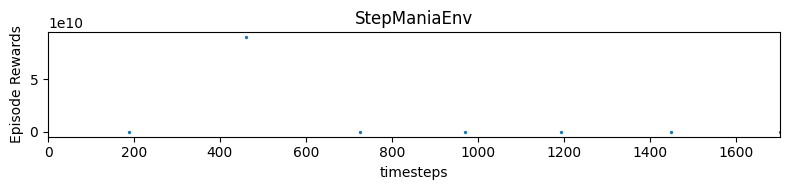

In [18]:
from stable_baselines3.common import results_plotter

results_plotter.plot_results(
  [LOG_DIR], 1e10, results_plotter.X_TIMESTEPS, "StepManiaEnv"
)